# LightFM Model for EBNeRD Dataset

Source: https://github.com/recommenders-team/recommenders/blob/main/examples/02_model_collaborative_filtering/lightfm_deep_dive.ipynb

## Shell

In [1]:
!pip install lightfm
!pip install git+https://github.com/microsoft/recommenders.git

  Cloning https://github.com/microsoft/recommenders.git to /tmp/pip-req-build-qh1kr5il
  Running command git clone --filter=blob:none --quiet https://github.com/microsoft/recommenders.git /tmp/pip-req-build-qh1kr5il
  Resolved https://github.com/microsoft/recommenders.git to commit c2ea583d27bb1a4d58a09a1621d5ce95672ef1dc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Importing libraries

In [12]:
import os
import sys
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import lightfm
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm import cross_validation
from lightfm.evaluation import precision_at_k as lightfm_prec_at_k
from lightfm.evaluation import recall_at_k as lightfm_recall_at_k

from recommenders.evaluation.python_evaluation import precision_at_k, recall_at_k
from recommenders.utils.timer import Timer
from recommenders.datasets import movielens
from recommenders.models.lightfm.lightfm_utils import (
    track_model_metrics,
    prepare_test_df,
    prepare_all_predictions,
    compare_metric,
    similar_users,
    similar_items,
)
from recommenders.utils.notebook_utils import store_metadata

print("System version: {}".format(sys.version))
print("LightFM version: {}".format(lightfm.__version__))

System version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
LightFM version: 1.17


## Defining variables

In [13]:
# default number of recommendations
K = 10
# model learning rate
LEARNING_RATE = 0.25
# no of latent factors
NO_COMPONENTS = 20
# no of epochs to fit model
NO_EPOCHS = 20
# no of threads to fit model
NO_THREADS = 32
# regularisation for both user and item features
ITEM_ALPHA = 1e-6
USER_ALPHA = 1e-6

# seed for pseudonumber generations
SEED = 42

## Retrieving data

The data is pre-prepared to fit with the basic LightFM model. During data preparation, duplicate data, and common items between training and validation datasets are removed.

#### Retrieve training and test data - EBNeRD

In [14]:
train_data = pd.read_csv("/content/drive/MyDrive/SW6/Colab notebooks/LightFM/train_data.csv")
train_data.sample(5, random_state=SEED)

,userID,itemID,rating,genre
511060,1839028,9765804,1,Vejr
1887140,2203097,9750389,1,Transportmiddel
1444202,2560643,9769135,1,Økonomi
1020563,1346184,9765641,1,Transportmiddel
1005151,2040933,9763634,1,Samfund


In [15]:
test_data = pd.read_csv("/content/drive/MyDrive/SW6/Colab notebooks/LightFM/valid_data.csv")
test_data.sample(5, random_state=SEED)

,userID,itemID,rating,genre
1746453,2026473,9781906,0,Økonomi
2099717,34171,9772297,1,Kriminalitet
908256,985684,9339920,0,Livsstil
1937287,1505439,9785668,0,Kriminalitet
1992021,1832616,9673564,0,Økonomi


### Prepare data

LightFM requires internal mapping of userID and itemID. The mapping is shares accross training and validation to ensure consistency.

In [16]:
# Create a single Dataset instance to handle mappings for both datasets
dataset = Dataset()
dataset.fit(users=pd.concat([train_data['userID'], test_data['userID']]),
            items=pd.concat([train_data['itemID'], test_data['itemID']]))

### Sanity check

In [17]:
(train_interactions, train_weights) = dataset.build_interactions(train_data.iloc[:, 0:3].values)
(test_interactions, test_weights) = dataset.build_interactions(test_data.iloc[:, 0:3].values)

print(f"Shape of train interactions: {train_interactions.shape}")
print(f"Shape of validation interactions: {test_interactions.shape}")

Shape of train interactions: (18827, 11174)
Shape of validation interactions: (18827, 11174)


## Fit the LightFM model

In [18]:
model = LightFM(loss='warp', no_components=NO_COMPONENTS,
                learning_rate=LEARNING_RATE,
                random_state=np.random.RandomState(SEED))

In [19]:
model.fit(interactions=train_interactions, epochs=NO_EPOCHS);

## Get validation AUC score

In [20]:
from lightfm.evaluation import auc_score

# Exclude interactions in the training set from the test set
test_interactions_excl_train = test_interactions - train_interactions.multiply(test_interactions)

# Calculate AUC score
with Timer() as auc_time:
    auc_scores = auc_score(model, test_interactions=test_interactions_excl_train,
                           num_threads=NO_THREADS)

print(f"Took {auc_time.interval:.1f} seconds to calculate AUC scores.")

# Get the number of AUC scores and calculate the average AUC score
num_auc_scores = len(auc_scores)
average_auc_score = np.mean(auc_scores)

# Print the number of AUC scores and average AUC score
print("Number of AUC scores calculated:", num_auc_scores)
print("Average AUC score:", average_auc_score)

Took 73.0 seconds to calculate AUC scores.
Number of AUC scores calculated: 15342
Average AUC score: 0.5168388


## Track training and validation AUC score for each epoch to see convergence

Beware: Takes 40-50 minutes with 20 epochs

In [ ]:
import matplotlib.pyplot as plt

# Store AUC scores for each epoch
train_auc_scores_per_epoch = []
test_auc_scores_per_epoch = []

for epoch in range(NO_EPOCHS):
    # Fit model for current epoch
    model.fit_partial(interactions=train_interactions, epochs=1)

    # Calculate AUC score for current epoch
    train_auc_score_epoch = auc_score(model, train_interactions,
                                num_threads=NO_THREADS)

    test_auc_score_epoch = auc_score(model, test_interactions=test_interactions_excl_train,
                                num_threads=NO_THREADS)

    # Append AUC score to list
    train_auc_scores_per_epoch.append(np.mean(train_auc_score_epoch))
    test_auc_scores_per_epoch.append(np.mean(test_auc_score_epoch))

### Plot

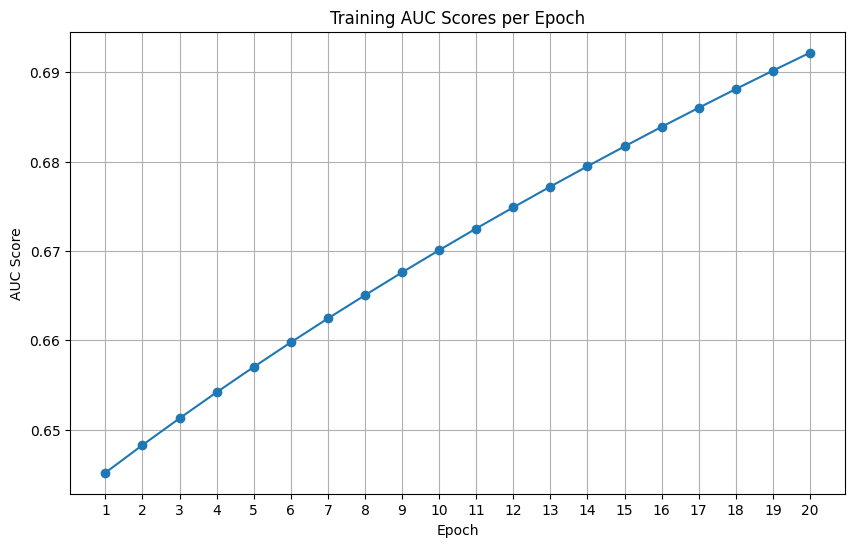

In [ ]:
# Plot AUC scores per epoch
plt.figure(figsize=(10, 6))
plt.plot(range(1, NO_EPOCHS + 1), train_auc_scores_per_epoch, marker='o', linestyle='-')
plt.title('Training AUC Scores per Epoch')
plt.xlabel('Epoch')
plt.ylabel('AUC Score')
plt.grid(True)
plt.xticks(range(1, NO_EPOCHS + 1))
plt.show()

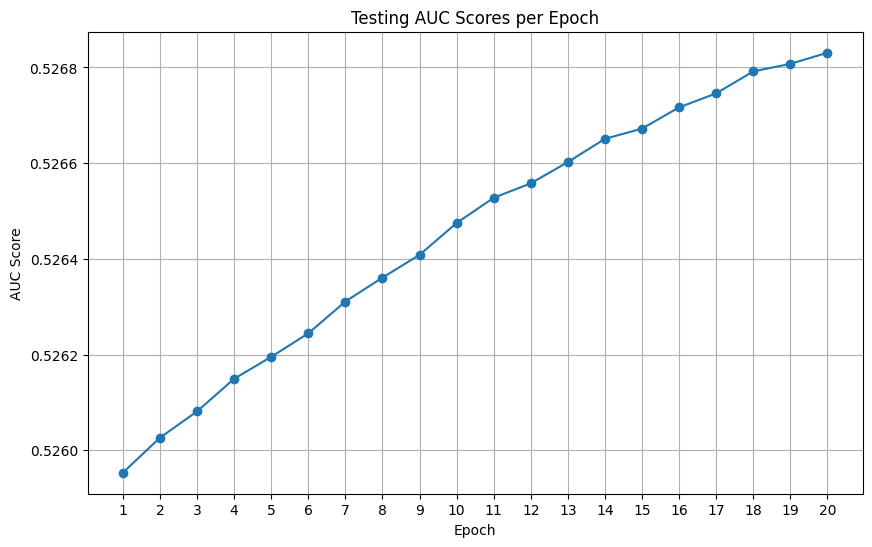

In [ ]:
# Plot AUC scores per epoch
plt.figure(figsize=(10, 6))
plt.plot(range(1, NO_EPOCHS + 1), test_auc_scores_per_epoch, marker='o', linestyle='-')
plt.title('Testing AUC Scores per Epoch')
plt.xlabel('Epoch')
plt.ylabel('AUC Score')
plt.grid(True)
plt.xticks(range(1, NO_EPOCHS + 1))
plt.show()

## Make single prediction with single user id input and all articles

In [ ]:
def make_predictions_for_user(user_id):
    # Get the internal user ID for the given user ID
    internal_user_id = dataset.mapping()[0][user_id]

    # Get all item IDs from the dataset
    all_item_ids = np.array(list(dataset.mapping()[2].values()))

    # Make predictions
    predictions = model.predict(internal_user_id, all_item_ids)

    # Retrieve actual article IDs corresponding to internal item IDs
    actual_item_ids = np.array(list(dataset.mapping()[2].keys()))

    # Sort predictions and actual_item_ids based on predictions
    sorted_indices = np.argsort(predictions)[::-1]  # Sort indices in descending order
    sorted_predictions = predictions[sorted_indices]
    sorted_item_ids = actual_item_ids[sorted_indices]

    # Create a DataFrame with sorted item IDs and corresponding predictions
    df = pd.DataFrame({'Article ID': sorted_item_ids, 'Prediction': sorted_predictions})

    return df

# Example usage:
user_id = 1078040  # Specify the user ID for whom you want to make predictions
predictions_df = make_predictions_for_user(user_id)
print(predictions_df)

       Article ID    Prediction
0         4106255  31970.966797
1         4190407  10581.774414
2         9723542  10325.455078
3         9696252  10087.260742
4         9780514   9272.480469
...           ...           ...
13013     9646579 -13294.722656
13014     9618626 -25670.769531
13015     7617965 -26545.292969
13016     4259774 -29295.019531
13017     9647704 -29300.923828

[13018 rows x 2 columns]


You can stop reading here, the rest of the notebook is not currently used.

## Export the model

In [21]:
import joblib
joblib.dump(model, 'lightfm_model_multi_file.joblib') # Use this one
#joblib.dump(model, 'lightfm_model.pkl')

['lightfm_model_multi_file_half.joblib']

## Other evaluation method from LightFM documentation (**takes forever!**)


### Prepare model evaluation data

In [ ]:
# Get mapping for train and test datasets
train_uid_map, train_ufeature_map, train_iid_map, train_ifeature_map = dataset.mapping()
test_uid_map, test_ufeature_map, test_iid_map, test_ifeature_map = dataset.mapping()
test_idx = slice(None, None)  # Use all data for testing

In [ ]:
with Timer() as test_time:
    test_df = prepare_test_df(test_idx, test_interactions.row, test_interactions.col,
                              test_uid_map, test_iid_map, test_weights)
print(f"Took {test_time.interval:.1f} seconds for preparing and predicting test data.")
time_reco1 = test_time.interval

In [ ]:
test_df.sample(5, random_state=SEED)

### Prepare all predictions takes approximately 62360 years, do not start it :^)

In [ ]:
with Timer() as test_time:
    all_predictions = prepare_all_predictions(test_data, test_uid_map, test_iid_map,
                                              interactions=test_interactions, model=model,
                                              num_threads=32)
print(f"Took {test_time.interval:.1f} seconds for preparing and predicting all data.")
time_reco2 = test_time.interval

In [ ]:
all_predictions.sample(5, random_state=SEED)

### Model evaluation

In [ ]:
with Timer() as test_time:
    eval_precision = precision_at_k(rating_true=test_df,
                                rating_pred=all_predictions, k=K)
    eval_recall = recall_at_k(test_df, all_predictions, k=K)
time_reco3 = test_time.interval

with Timer() as test_time:
    eval_precision_lfm = lightfm_prec_at_k(model, test_interactions,
                                           train_interactions, k=K).mean()
    eval_recall_lfm = lightfm_recall_at_k(model, test_interactions,
                                          train_interactions, k=K).mean()
time_lfm = test_time.interval

print(
    "------ Using Repo's evaluation methods ------",
    f"Precision@K:\t{eval_precision:.6f}",
    f"Recall@K:\t{eval_recall:.6f}",
    "\n------ Using LightFM evaluation methods ------",
    f"Precision@K:\t{eval_precision_lfm:.6f}",
    f"Recall@K:\t{eval_recall_lfm:.6f}",
    sep='\n')

### Export all predictions

In [ ]:
# Define the file path where you want to save the predictions
predictions_file_path = 'model_predictions.csv'

# Export all predictions to a CSV file
all_predictions.to_csv(predictions_file_path, index=False)
print(f"All model predictions exported successfully to {predictions_file_path}")

### Finding predictions for a user_id from all predictions

In [ ]:
def get_top_predictions_for_user(user_id, all_predictions_df, k=10):
    user_predictions = all_predictions_df[all_predictions_df['userID'] == user_id]
    top_predictions = user_predictions.sort_values(by='prediction', ascending=False).head(k)
    return top_predictions

# Example usage: Get top predictions for user with ID
user_id = 1090366
top_predictions_for_user = get_top_predictions_for_user(user_id, all_predictions)
print(f"Top {K} predictions for user {user_id}:")
print(top_predictions_for_user)

## Utilities

### Exporting the model

In [ ]:
import joblib

# Define the file path where you want to save the model
model_file_path = 'lightfm_model.pkl'

# Export the model
joblib.dump(model, model_file_path)
print(f"Model exported successfully to {model_file_path}")

### Importing the model

In [ ]:
# Define the file path from where you want to load the model
loaded_model = joblib.load(model_file_path)

# Check if the loaded object is an instance of the LightFM model class
if isinstance(loaded_model, LightFM):
    print("Model loaded successfully!")
else:
    print("Failed to load the model. Please check the file path or the model file.")
